### Technical Assessment

A Supervision Manager has asked you to help in allocating scarce resources, and identify which firms their team should focus on. Supervisory resource may be allocated according to the following characteristics:  

- Firm size (i.e. the biggest firms need more attention)  
- Changing business profile (are firms’ data changing substantially year-on-year?)  
- Outliers from the norm (when looking at a single reporting period, does a firm deviate significantly from the average?)  


Some typical metrics have been provided in the attached data sheets. These include:  

- Gross Written Premium (GWP) – total revenue written by an insurer. Equivalent of turnover for a non-insurance firm.  
- Net Written Premium (NWP) – GWP less reinsurance. NWP / GWP will show how much of the firm’s risk is being passed on to reinsurers.  
- SCR coverage ratio – a measure of whether a firm is meeting its prudential capital requirements. Greater than 100% means the firm is holding enough capital to meet the requirement. The size of the buffer (i.e. surplus over 100%) can be important.  
- Gross claims incurred – a large cost to an insurer. Monitoring how these change over time for a firm is vital.  
- Net combined ratio – (incurred losses plus expenses) / earned premiums. This is a ratio that can indicate the profitability of a firm. If this is less than 100% it indicates a profit.  

### Task  

Using the data provided, please analyse this data using R or Python and produce a short report, including tables and charts, to highlight which firms should receive the most supervisory attention, according to the metrics above. 

### Contents

#### - <a href='#libraries'>Relevant Python libraries</a>
#### - <a href='#functions'>Relevant custom functions</a>
#### - <a href='#loading'>Data Loading and Cleaning</a>
#### - <a href='#exploratory'>Exploratory Data Analysis</a>
#### - <a href='#GWP'>GWP</a>
#### - <a href='#NWP'>NWP</a>
#### - <a href='#NWPGWP'>NWP/GWP</a>
#### - <a href='#SCRCR'>SCR coverage ratio</a>
#### - <a href='#GCI'>Gross claims incurred</a>
#### - <a href='#NCR'>Net combined ratio</a>
#### - <a href='#TA'>Total assets</a>
#### - <a href='#Summary'>Summary</a>

<a id='libraries'></a>

### Relevant Python libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 30)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
import warnings
warnings.filterwarnings('ignore')

<a id='functions'></a>

### Relevant custom functions

#### Function for importing

In [2]:
# To import excel files into dataframes
def func_import_xls(filename, sheetname, header, index_col):
    df = pd.read_excel(filename, sheetname, header, index_col=index_col)
    return df

#### Function for zero values

In [3]:
# To show firms in dataframe showing all zeros in the whole row
def func_check_zeros_row(df):
    return df.loc[(df==0).all(axis=1)]

# To show a list of firms showing all zeros in the whole row
def func_check_zeros_row_list(df):
    return list(df.loc[(df==0).all(axis=1)].index)

# To remove firms showing all zeros in the whole row
def func_remove_zeros_row(df):
    return df.loc[~(df==0).all(axis=1)]

#### Function for selecting specific columns for each metric

In [4]:
# To select a subset of dataset from specific metric
def func_match_dataframe(metric):
    match metric:
        case 'GWP (£m)':
            df = df_gwp
        case 'NWP (£m)':
            df = df_nwp
        case 'SCR coverage ratio':
            df = df_scrcr
        case 'Gross claims incurred (£m)':
            df = df_gci
        case 'Net combined ratio':
            df = df_ncr
        case 'Total assets (£m)':
            df = df_ta
    return df

#### Function for plotting and drawing average line

In [5]:
# To plot the distribution using boxplot over the years
def func_plot_distribution_5yr(metric):
    df = func_match_dataframe(metric)
    ax = df[[('2016YE'), ('2017YE'), ('2018YE'), ('2019YE'), ('2020YE')]].plot(
            kind = 'box', title = metric+' distribution', flierprops={'marker': '.', 'markersize': 7})
    ax.set_ylabel(metric)

# To draw a horizontal line to identify outliers
def func_draw_dashed_line(val):
    plt.axhline(y = val, linestyle = '--', color = 'red', 
                label = ('£'+str(val)+'m' if val >= 0 else '-£'+str(abs(val))+'m'))
    plt.legend()

#### Function for finding firms over/below custom values

In [6]:
# To find the firms which values are over the custom value
def func_firms_values_over(metric, val):
    df = func_match_dataframe(metric)
    ls_over = []
    for year in df:
        column = df[(df[year] > val)].index.tolist()
        for x in column:
            ls_over.append(x)
    return natsorted(list(set(ls_over)))

# To find the firms which values are below the custom value
def func_firms_values_below(metric, val):
    df = func_match_dataframe(metric)
    ls_below = []
    for year in df:
        column = df[(df[year] < val)].index.tolist()
        for x in column:
            ls_below.append(x)
    return natsorted(list(set(ls_below)))

# To find the firms which values are below the custom value in 2022
def func_firms_values_below_2020(metric, val):
    df = func_match_dataframe(metric)
    ls_below_2020 = []
    column = df[(df['2020YE'] < val)].index.tolist()
    for x in column:
        ls_below_2020.append(x)
    return natsorted(list(set(ls_below_2020)))

#### Function for finding and visualising top 10 firms 

In [7]:
# To find the top 10 firms in 2020 in terms of metric
def func_top_10_2020(metric):
    df = func_match_dataframe(metric)
    return pd.DataFrame(df[('2020YE')].sort_values(ascending = False).head(10))

# To plot the top 10 firms in 2020 in terms of metric using bar chart
def func_plot_bar_top10_2020(metric, df_top):
    fig = plt.figure(figsize=(10,5))
    plt.bar(df_top.index, df_top[('2020YE')])
    plt.ylabel(metric)
    plt.title('Top ' + metric + ' in year 2020')
    for i in range(len(df_top.index)):
        plt.text(i, df_top[('2020YE')][i], round(df_top[('2020YE')][i], 2), ha='center')

#### Function for computing and visualising relative change

In [8]:
# To compute the relative change over the years
def func_relative_change(metric):
    df = func_match_dataframe(metric)
    df['16-17YE'] = (df['2017YE'] - df['2016YE']) / df['2016YE']
    df['17-18YE'] = (df['2018YE'] - df['2017YE']) / df['2017YE']
    df['18-19YE'] = (df['2019YE'] - df['2018YE']) / df['2018YE']
    df['19-20YE'] = (df['2020YE'] - df['2019YE']) / df['2019YE']
    df['16-20YE'] = (df['2020YE'] - df['2016YE']) / df['2016YE']
    df.replace(np.inf, 1, inplace = True)
    df.replace(-np.inf, -1, inplace = True)
    df.replace(np.nan, 0, inplace = True)
    return df.iloc[:,-5:]

# To plot the degree of relative change using heatmap
def func_heatmap_relative_change(tbl):
    sns.heatmap(tbl, annot = True, cmap = 'coolwarm', linewidth = .5, fmt = '.2f', vmin = -50, vmax = 50)
    plt.xlabel('Relative Change')

<a id='loading'></a>
### Data Loading and Cleaning

In [9]:
### Put the excel file into the same directory as this notebook
# To load the data into dataframes
file = 'Data for technical assessment.xlsx'
ds1 = func_import_xls(file, 'Dataset 1 - General', header=[0,1], index_col=0)
ds2 = func_import_xls(file, 'Dataset 2 - Underwriting', header=[0,1], index_col=0)

In [10]:
ds1.head()

NWP (£m)                                                SCR (£m)  \
            2016YE     2017YE     2018YE     2019YE     2020YE     2016YE   
Firm 1 -13779.8156     0.0000     0.0000     0.0000     0.0000  1085.3601   
Firm 2     28.1781    26.8650    25.0644    23.2264    21.7186    10.1903   
Firm 3      0.0000    75.6097    70.5787    78.4328    85.7358   322.9551   
Firm 4  22344.1999 23963.9107 25760.3902 25512.7488 24996.0210 16573.6448   
Firm 5     68.2010    51.6631    44.0108    42.0086    81.2737    52.8244   

                                                    ...  \
           2017YE     2018YE     2019YE     2020YE  ...   
Firm 1     0.0000     0.0000     0.0000     0.0000  ...   
Firm 2    10.1136     9.4952     8.1465     7.3246  ...   
Firm 3   363.7823   362.2909   394.2960   400.6995  ...   
Firm 4 16332.7488 17103.6160 17219.2461 19600.2621  ...   
Firm 5    38.0538    34.6968    57.2318    66.2308  ...   

       Total liabilities (£m)                                              \
                       2016YE     2017YE     2018YE     2019YE     2020YE   
Firm 1             69696.5571     0.0000     0.0000     0.0000     0.0000   
Firm 2                 8.5263     9.5857     8.5960     6.9329     8.5263   
Firm 3               926.0657  1016.4017   974.7339  1032.4970  1214.9133   
Firm 4             50485.0106 56618.7062 62935.2444 64005.5480 71237.7110   
Firm 5               193.4258   161.4177   118.9109   107.2698   104.9221   

       Excess of assets over liabilities (£m) [= equity]             \
                                                  2016YE     2017YE   
Firm 1                                         2031.0359     4.8179   
Firm 2                                           33.3912    40.6373   
Firm 3                                          583.6506   558.9169   
Firm 4                                        16919.3385 16415.9230   
Firm 5                                          148.4335   150.0913   

                                         
           2018YE     2019YE     2020YE  
Firm 1     0.0000     0.0000     0.0000  
Firm 2    50.6216    57.6023    29.6524  
Firm 3   566.0733   598.3387   540.0657  
Firm 4 18249.5848 20795.9760 22827.3700  
Firm 5   152.2052   142.4791   130.5598  

[5 rows x 40 columns]

In [11]:
ds2.head()

Gross claims incurred (£m)                                      \
                           2016YE   2017YE   2018YE   2019YE   2020YE   
Firm 1                     0.0000   0.0467   0.0000   0.0000   0.0000   
Firm 2                    39.2411  35.9482  29.0022   0.0000   0.0000   
Firm 3                     0.0000   0.0000   0.0000   0.0000   0.0000   
Firm 4                    17.1260  75.5360 119.4270  35.8842   6.5680   
Firm 5                    30.4852 247.8730 449.8747 348.5363 373.7868   

       Gross BEL (inc. TPs as whole, pre-TMTP) (£m)                    \
                                             2016YE   2017YE   2018YE   
Firm 1                                       0.0000   7.6745   0.0000   
Firm 2                                     163.5979 195.5299 201.5330   
Firm 3                                       0.0000   0.0000   0.0000   
Firm 4                                     -18.2971  22.6401  80.3838   
Firm 5                                      20.8005 128.2290 349.4108   

                          ... Gross expense ratio                        \
         2019YE   2020YE  ...              2016YE  2017YE 2018YE 2019YE   
Firm 1   0.0000   0.0000  ...              0.0000 56.8137 0.0000 0.0000   
Firm 2   0.0000   0.0000  ...              0.7433  0.9635 0.8146 0.0000   
Firm 3   0.0000   0.0000  ...              0.0000  0.0000 0.0000 0.0000   
Firm 4  99.5691  43.5723  ...              0.1439  0.1475 0.0930 0.0548   
Firm 5 314.0696 409.1618  ...              0.1772  0.1343 0.1091 0.1210   

               Gross combined ratio                                 
        2020YE               2016YE  2017YE 2018YE 2019YE   2020YE  
Firm 1  0.0000               0.0000 68.2152 0.0000 0.0000   0.0000  
Firm 2  0.0000               0.9454  1.1267 0.9392 0.0000   0.0000  
Firm 3  0.0000               0.0000  0.0000 0.0000 0.0000   0.0000  
Firm 4 -0.5462               0.8480  1.4748 1.7280 1.2088 -10.7361  
Firm 5  0.1092               0.5087  1.2595 1.3042 0.9833   0.9972  

[5 rows x 45 columns]

In [12]:
# To check the column type and any missing values using info()
ds1.info()
ds2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325 entries, Firm 1 to Firm 325
Data columns (total 40 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   (NWP (£m) , 2016YE)                                          325 non-null    float64
 1   (NWP (£m) , 2017YE)                                          325 non-null    float64
 2   (NWP (£m) , 2018YE)                                          325 non-null    float64
 3   (NWP (£m) , 2019YE)                                          325 non-null    float64
 4   (NWP (£m) , 2020YE)                                          325 non-null    float64
 5   (SCR (£m), 2016YE)                                           325 non-null    float64
 6   (SCR (£m), 2017YE)                                           325 non-null    float64
 7   (SCR (£m), 2018YE)                                           325 non-null  

There are no missing values (i.e. all non-null values) and values are in float type. I will rename the column name from 'NWP (£m) ' to 'NWP (£m)' to avoid any compilation issue as there is currently a space at the end.  
These two dataframes are consistent, showing metrics from 2016YE to 2020YE and firms from 1 to 325. To make sure they are the same format, I will perform checks in code. 

In [13]:
# To rename column name from 'NWP (£m) ' to 'NWP (£m)'
ds1 = ds1.rename(columns={'NWP (£m) ': 'NWP (£m)'})

In [14]:
# To check if two tables are in same years and their indexes match
ds1_years, ds2_years = set(), set()

for i in range(len(ds1.columns)):
    ds1_years.add(ds1.columns[i][1])
for i in range(len(ds2.columns)):
    ds2_years.add(ds2.columns[i][1])
print('Check if the years in two tables are the same:', ds1_years == ds2_years)
print('Check if the firm indexes in two tables are the same:', all(ds1.index == ds2.index))

Check if the years in two tables are the same: True
Check if the firm indexes in two tables are the same: True


Since they are in the same format and small sizes, I would join two dataframes into one single dataframe.

In [15]:
# To join two dataframes into one single dataframe
df = ds1.merge(ds2, left_index = True, right_index = True)
df.head()

NWP (£m)                                               SCR (£m)  \
            2016YE     2017YE     2018YE     2019YE     2020YE     2016YE   
Firm 1 -13779.8156     0.0000     0.0000     0.0000     0.0000  1085.3601   
Firm 2     28.1781    26.8650    25.0644    23.2264    21.7186    10.1903   
Firm 3      0.0000    75.6097    70.5787    78.4328    85.7358   322.9551   
Firm 4  22344.1999 23963.9107 25760.3902 25512.7488 24996.0210 16573.6448   
Firm 5     68.2010    51.6631    44.0108    42.0086    81.2737    52.8244   

                                                    ... Gross expense ratio  \
           2017YE     2018YE     2019YE     2020YE  ...              2016YE   
Firm 1     0.0000     0.0000     0.0000     0.0000  ...              0.0000   
Firm 2    10.1136     9.4952     8.1465     7.3246  ...              0.7433   
Firm 3   363.7823   362.2909   394.2960   400.6995  ...              0.0000   
Firm 4 16332.7488 17103.6160 17219.2461 19600.2621  ...              0.1439   
Firm 5    38.0538    34.6968    57.2318    66.2308  ...              0.1772   

                                     Gross combined ratio                 \
        2017YE 2018YE 2019YE  2020YE               2016YE  2017YE 2018YE   
Firm 1 56.8137 0.0000 0.0000  0.0000               0.0000 68.2152 0.0000   
Firm 2  0.9635 0.8146 0.0000  0.0000               0.9454  1.1267 0.9392   
Firm 3  0.0000 0.0000 0.0000  0.0000               0.0000  0.0000 0.0000   
Firm 4  0.1475 0.0930 0.0548 -0.5462               0.8480  1.4748 1.7280   
Firm 5  0.1343 0.1091 0.1210  0.1092               0.5087  1.2595 1.3042   

                        
       2019YE   2020YE  
Firm 1 0.0000   0.0000  
Firm 2 0.0000   0.0000  
Firm 3 0.0000   0.0000  
Firm 4 1.2088 -10.7361  
Firm 5 0.9833   0.9972  

[5 rows x 85 columns]

In [16]:
# To check any rows containing all zeros
func_check_zeros_row(df)

NWP (£m)                             SCR (£m)                       \
           2016YE 2017YE 2018YE 2019YE 2020YE   2016YE 2017YE 2018YE 2019YE   
Firm 119   0.0000 0.0000 0.0000 0.0000 0.0000   0.0000 0.0000 0.0000 0.0000   
Firm 176   0.0000 0.0000 0.0000 0.0000 0.0000   0.0000 0.0000 0.0000 0.0000   

                 ... Gross expense ratio                              \
         2020YE  ...              2016YE 2017YE 2018YE 2019YE 2020YE   
Firm 119 0.0000  ...              0.0000 0.0000 0.0000 0.0000 0.0000   
Firm 176 0.0000  ...              0.0000 0.0000 0.0000 0.0000 0.0000   

         Gross combined ratio                              
                       2016YE 2017YE 2018YE 2019YE 2020YE  
Firm 119               0.0000 0.0000 0.0000 0.0000 0.0000  
Firm 176               0.0000 0.0000 0.0000 0.0000 0.0000  

[2 rows x 85 columns]

There are two firms which shows all zeros in the whole row. It appears to be either the firm is not in operation or there is error in reporting. Therefore I will remove them for accurate analysis. And I checked for any duplicated rows.

In [17]:
# To remove rows containing all zeros
df_cleaned = func_remove_zeros_row(df)

In [18]:
# To check any duplicated rows
df_cleaned.duplicated().sum()

0

<a id='exploratory'></a>

### Exploratory Data Analysis

In [19]:
# To show the statistics for each year
df_cleaned.describe()

NWP (£m)                                               SCR (£m)  \
           2016YE     2017YE     2018YE     2019YE     2020YE     2016YE   
count    323.0000   323.0000   323.0000   323.0000   323.0000   323.0000   
mean     641.5549   804.5620   849.2572   787.2176   662.4267   359.9429   
std     3870.5571  3297.0627  3697.9621  3463.5177  3045.2789  1390.2007   
min   -13779.8156 -2305.8543  -193.0833  -181.6121 -1336.5533     0.0000   
25%        0.0000     0.0000     0.0000     0.0000     0.0000     3.3353   
50%        4.6593    10.8276    10.5454     7.3100     3.1381    23.1184   
75%      109.7626   192.9201   181.3274   107.2851    66.8607   126.1400   
max    45309.8387 38199.3113 48117.9937 44638.7696 40135.6923 16573.6448   

                                                   ... Gross expense ratio  \
          2017YE     2018YE     2019YE     2020YE  ...              2016YE   
count   323.0000   323.0000   323.0000   323.0000  ...            323.0000   
mean    357.1583   334.3503   327.1831   324.2993  ...             -0.7082   
std    1461.2902  1339.9333  1352.3855  1462.2140  ...             27.4019   
min       0.0000     0.0000     0.0000     0.0000  ...           -380.3848   
25%       2.5730     1.8974     0.9743     0.0000  ...              0.0000   
50%      21.3231    15.3007    12.5505     9.3590  ...              0.1329   
75%     108.5553   108.7772    99.9399    79.7361  ...              0.3453   
max   16332.7488 17103.6160 17219.2461 19600.2621  ...            195.8270   

                                                 Gross combined ratio  \
          2017YE    2018YE       2019YE   2020YE               2016YE   
count   323.0000  323.0000     323.0000 323.0000             323.0000   
mean    -19.5026   13.3393    4155.2291   6.0740              -0.8194   
std     495.7934  227.4137   74674.2801  57.8844              39.3328   
min   -8773.1588   -0.2845    -217.1850  -0.8191            -512.1248   
25%       0.0000    0.0000       0.0000   0.0000               0.0000   
50%       0.2279    0.2135       0.1836   0.1135               0.5400   
75%       0.3553    0.3497       0.3309   0.3299               0.9193   
max    1302.8859 4087.2645 1342061.3085 783.6799             198.2779   

                                                     
           2017YE     2018YE       2019YE    2020YE  
count    323.0000   323.0000     323.0000  323.0000  
mean     -92.3272    39.7064   10063.7573   15.9365  
std     1934.2719   690.5248  181011.6803  139.7387  
min   -34649.4248  -158.9569   -2907.6265  -10.7361  
25%        0.0000     0.0000       0.0000    0.0000  
50%        0.7735     0.7225       0.6226    0.2843  
75%        1.0260     0.9759       0.9505    0.9584  
max     2122.6570 12408.5374 3253168.8596 1916.1027  

[8 rows x 85 columns]

In [20]:
# To find the statistics over the years for each metric
df_cleaned = df_cleaned.rename_axis(columns=['Metrics', 'Year'])
df_cleaned.index.name = 'Firm'

# To unstack the dataframe to change column/index
df_cleaned_stats = df_cleaned.unstack()
df_cleaned_stats = df_cleaned_stats.unstack(0)
func_check_zeros_row(df_cleaned_stats)

Metrics          EoF for SCR (£m)  \
Year   Firm                         
2016YE Firm 62             0.0000   
       Firm 65             0.0000   
       Firm 68             0.0000   
       Firm 90             0.0000   
       Firm 98             0.0000   
...                           ...   
2020YE Firm 257            0.0000   
       Firm 269            0.0000   
       Firm 277            0.0000   
       Firm 290            0.0000   
       Firm 293            0.0000   

Metrics          Excess of assets over liabilities (£m) [= equity]  GWP (£m)  \
Year   Firm                                                                    
2016YE Firm 62                                              0.0000    0.0000   
       Firm 65                                              0.0000    0.0000   
       Firm 68                                              0.0000    0.0000   
       Firm 90                                              0.0000    0.0000   
       Firm 98                                              0.0000    0.0000   
...                                                            ...       ...   
2020YE Firm 257                                             0.0000    0.0000   
       Firm 269                                             0.0000    0.0000   
       Firm 277                                             0.0000    0.0000   
       Firm 290                                             0.0000    0.0000   
       Firm 293                                             0.0000    0.0000   

Metrics          Gross BEL (inc. TPs as whole, pre-TMTP) (£m)  \
Year   Firm                                                     
2016YE Firm 62                                         0.0000   
       Firm 65                                         0.0000   
       Firm 68                                         0.0000   
       Firm 90                                         0.0000   
       Firm 98                                         0.0000   
...                                                       ...   
2020YE Firm 257                                        0.0000   
       Firm 269                                        0.0000   
       Firm 277                                        0.0000   
       Firm 290                                        0.0000   
       Firm 293                                        0.0000   

Metrics          Gross claims incurred (£m)  Gross combined ratio  \
Year   Firm                                                         
2016YE Firm 62                       0.0000                0.0000   
       Firm 65                       0.0000                0.0000   
       Firm 68                       0.0000                0.0000   
       Firm 90                       0.0000                0.0000   
       Firm 98                       0.0000                0.0000   
...                                     ...                   ...   
2020YE Firm 257                      0.0000                0.0000   
       Firm 269                      0.0000                0.0000   
       Firm 277                      0.0000                0.0000   
       Firm 290                      0.0000                0.0000   
       Firm 293                      0.0000                0.0000   

Metrics          Gross expense ratio  NWP (£m)  \
Year   Firm                                      
2016YE Firm 62                0.0000    0.0000   
       Firm 65                0.0000    0.0000   
       Firm 68                0.0000    0.0000   
       Firm 90                0.0000    0.0000   
       Firm 98                0.0000    0.0000   
...                              ...       ...   
2020YE Firm 257               0.0000    0.0000   
       Firm 269               0.0000    0.0000   
       Firm 277               0.0000    0.0000   
       Firm 290               0.0000    0.0000   
       Firm 293               0.0000    0.0000   

Metrics          Net BEL (inc. TPs as a whole, pre-TMTP) (£m)  \
Year   Firm      

After the unstack operation, there are 74 firms which contain all zeros in metrics in a specific year. Again, it appears to be either the firm is not in operation or there is error in reporting in that year. Therefore I will remove them for accurate analysis.

In [21]:
# To remove rows containing all zeros
df_cleaned_stats = func_remove_zeros_row(df_cleaned_stats)
df_cleaned_stats.describe()

Metrics,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)",Gross claims incurred (£m),Gross combined ratio,Gross expense ratio,NWP (£m),"Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Net combined ratio,Net expense ratio,Pure gross claims ratio,Pure net claims ratio,SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m)
count,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000,1541.0000
mean,555.3761,553.1236,970.4825,310.6466,145.0284,2101.5444,870.7861,784.9714,201.2285,1552.5781,938.5883,1230.7583,613.9898,356.9420,1256279.3221,7684.7539,7131.6304
std,2124.9959,2070.6882,3961.2535,871.4588,412.0996,82877.1557,34188.7200,3562.4129,605.4195,61914.4401,36968.4299,48688.9856,24953.6941,1431.7321,30046950.3404,31207.9056,29831.1403
min,-110.7930,-110.7930,-95.4244,-135.4924,-98.0003,-34649.4248,-8773.1588,-13779.8156,-104.8387,-46116.6968,-8766.0574,-25876.2660,-37350.6394,0.0000,-1.9744,-217.4298,-1521.3344
25%,8.3346,8.3346,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3995,1.2985,21.0685,3.9053
50%,39.3104,39.7900,18.1764,13.1829,4.7652,0.7321,0.2161,9.8398,6.1744,0.7801,0.2292,0.3235,0.2577,18.5324,1.7281,134.8445,81.2331
75%,196.4743,190.7345,253.7092,215.4564,103.4480,0.9779,0.3468,152.3920,129.2062,1.0044,0.4152,0.6549,0.6265,110.4343,2.8417,1102.1976,806.7395
max,28772.4926,24786.1385,48117.9937,10094.5807,4487.9094,3253168.8596,1342061.3085,48117.9937,7539.1188,2430022.8396,1451186.5315,1911107.5512,978836.3081,19600.2621,963584000.0000,332875.9036,331981.9420


Using describe would give an overview of the statistics for metrics. To better understand the data, I would find their correlations.

<Axes: xlabel='Metrics', ylabel='Metrics'>

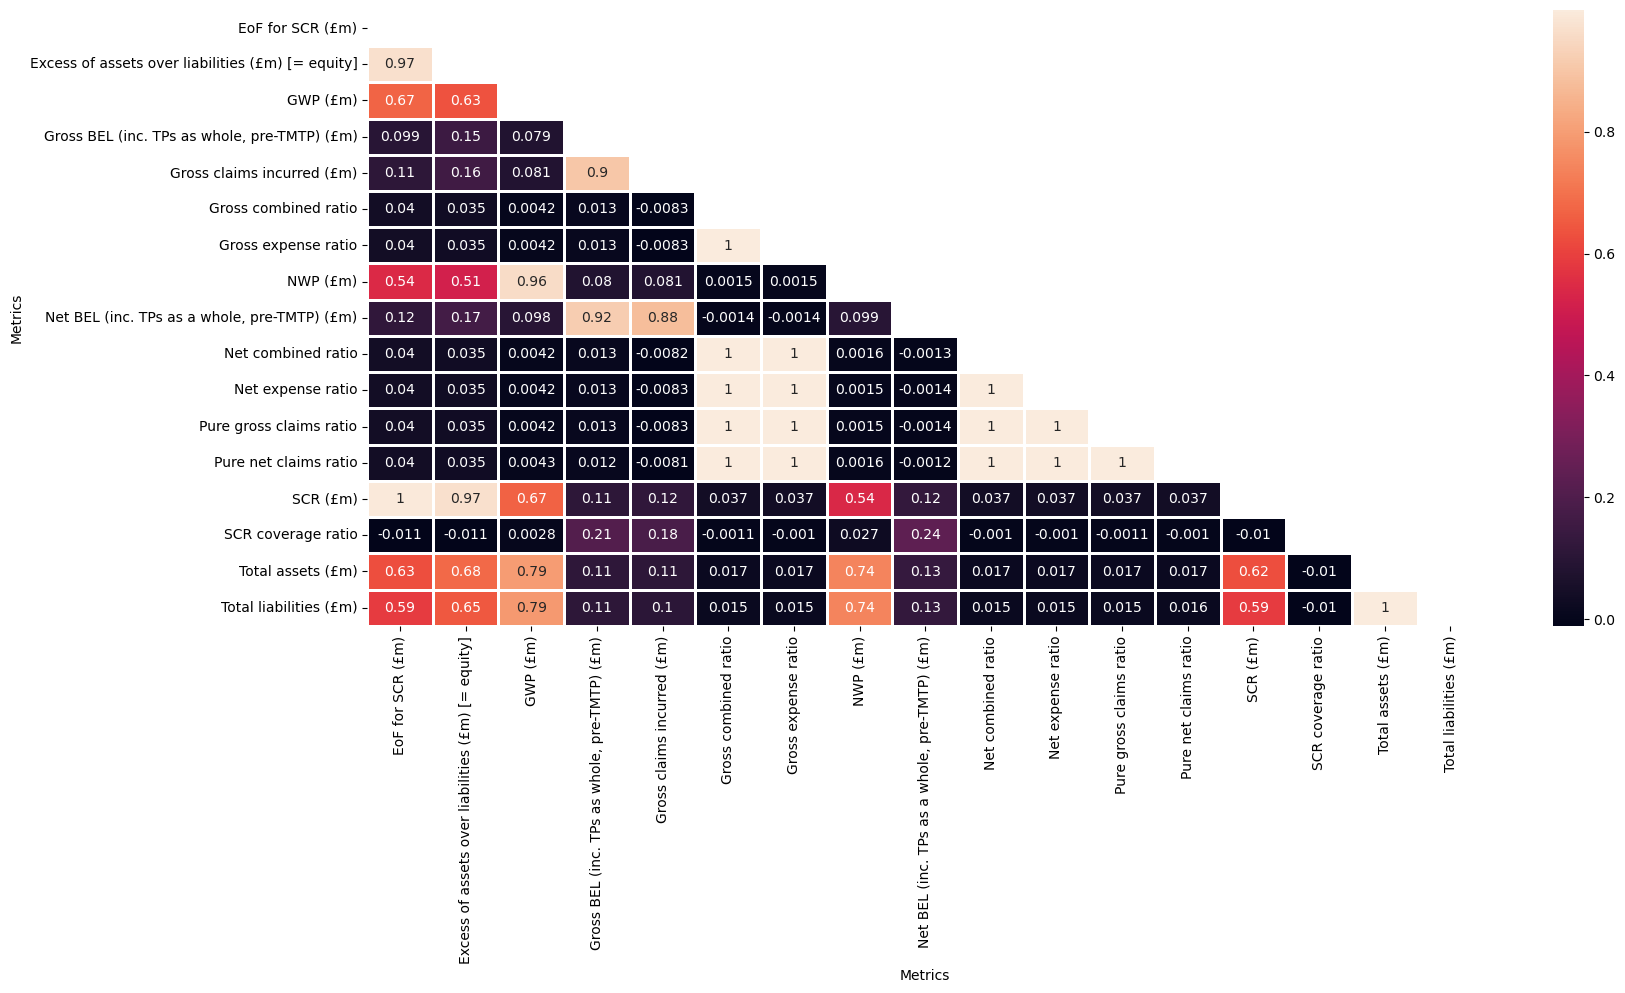

In [22]:
# To find out how each metric correlate with each other
corr = df_cleaned_stats.corr()

# To visualise the correlation coefficients 
plt.figure(figsize=(18,8))
sns.heatmap(corr, annot=True, mask=np.triu(corr), linewidths=.8)

It appears that GWP and NWP are significantly positively correlated. It means one tends to increase when the other one increases. 

<a id='GWP'></a>

### GWP
###### total revenue written by an insurer. Equivalent of turnover for a non-insurance firm.

#### GWP - Distribution & Outliers

In [23]:
df_gwp = df_cleaned['GWP (£m)']
df_gwp

Year,2016YE,2017YE,2018YE,2019YE,2020YE
Firm,,,,,
Firm 1,1409.4848,0.0000,0.0000,0.0000,0.0000
Firm 2,28.1781,26.8650,25.0644,23.2264,21.7186
Firm 3,0.0000,85.8102,79.5496,91.8141,96.4166
Firm 4,29424.5747,32935.4014,35867.6380,36135.4631,34922.7026
Firm 5,70.1561,52.3985,44.4556,42.3283,83.6684
...,...,...,...,...,...
Firm 321,0.0000,0.0000,10.7736,11.9750,46.1270
Firm 322,2193.4640,2178.6814,2161.6431,2228.8130,2179.2421
Firm 323,0.0000,0.0000,0.0000,0.0000,0.0000


In [24]:
# To check any firms containing all zeros
print('Total number of firms containing all zeros in terms of GWP:', len(func_check_zeros_row_list(df_gwp)))
df_gwp_all0 = df_gwp.index[(df_gwp==0).all(axis=1)].tolist()

# Remove these firms for statistics
df_gwp = df_gwp.loc[~(df_gwp==0).all(axis=1)]

Total number of firms containing all zeros in terms of GWP: 57


In [25]:
# To give an overview of the statistics
df_gwp.describe()

Year,2016YE,2017YE,2018YE,2019YE,2020YE
count,266.0000,266.0000,266.0000,266.0000,266.0000
mean,1028.9142,1111.5664,1278.9329,1188.1921,1014.6257
std,4379.7251,3891.8504,4571.0086,4402.8456,3957.5870
min,-13.8734,-4.9480,-7.9171,-0.1518,-95.4244
25%,0.0756,4.7324,4.3602,0.2244,0.0000
50%,28.2371,52.5256,53.4851,32.2214,20.7747
75%,310.2714,373.7467,344.2775,317.4447,313.2928
max,45309.8198,38199.3113,48117.9937,44638.7696,40135.6923


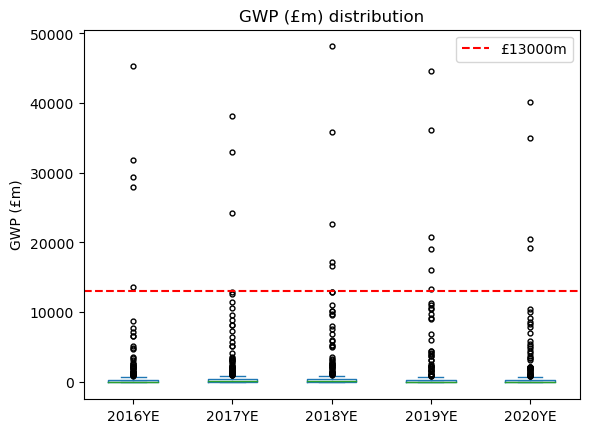

In [26]:
# To visualise the GWP (£m) distribution
func_plot_distribution_5yr('GWP (£m)')

# To add a dash line to identify outliers
func_draw_dashed_line(13000)

In [27]:
# To find the firms which GWP values are over £13000m
ls_gwp_over = func_firms_values_over('GWP (£m)', 13000)
print('Firms having GWP outlier over £13000m:', str(len(ls_gwp_over)) + ' firms')
print(ls_gwp_over)

Firms having GWP outlier over £13000m: 9 firms
['Firm 4', 'Firm 26', 'Firm 34', 'Firm 73', 'Firm 101', 'Firm 105', 'Firm 210', 'Firm 247', 'Firm 311']


In [28]:
# To find the firms which have negative GWP values
ls_gwp_below = func_firms_values_below('GWP (£m)', 0)
print('Firms having negative GWP over the years:', str(len(ls_gwp_below)) + ' firms')
print(ls_gwp_below)
print()
ls_gwp_below_2020 = func_firms_values_below_2020('GWP (£m)', 0)
print('Firms having negative GWP in 2020:', str(len(ls_gwp_below_2020)) + ' firms')
print(ls_gwp_below_2020)
# df_gwp.drop(index = ls_gwp_below, inplace = True)

Firms having negative GWP over the years: 20 firms
['Firm 31', 'Firm 55', 'Firm 56', 'Firm 61', 'Firm 96', 'Firm 144', 'Firm 152', 'Firm 186', 'Firm 205', 'Firm 207', 'Firm 225', 'Firm 230', 'Firm 233', 'Firm 245', 'Firm 277', 'Firm 278', 'Firm 289', 'Firm 303', 'Firm 313', 'Firm 316']

Firms having negative GWP in 2020: 4 firms
['Firm 55', 'Firm 152', 'Firm 233', 'Firm 316']


From the graph, all the circles are identified as outliers. However, some of them are genuine. I put those over £13000m as extreme outliers to receive supervisory attention. Moreover, high GWP may be the cause of large firm size, which also need more attention. 
</br>  
GWP is assumed to be non-negative, as it means turnover for a company. However, there are 20 firms which recorded negative GWP. It appears to be errors in reporting. They should receive attention but I will delete these for further analysis.

#### GWP - Firm size

,2020YE
Firm,
Firm 210,40135.6923
Firm 4,34922.7026
Firm 34,20510.7506
Firm 311,19180.0165
Firm 26,10489.2481
Firm 247,9961.5207
Firm 199,9149.5837
Firm 7,8652.9474
Firm 151,8341.6433


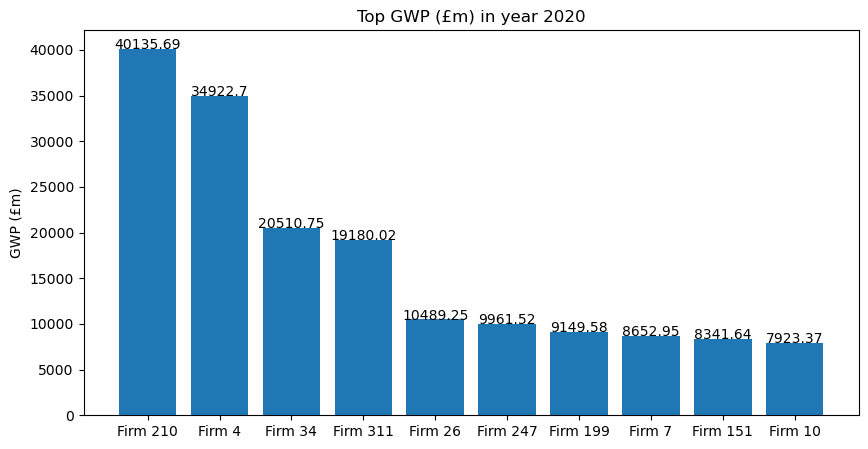

In [29]:
# To plot the top 10 GWP using bar charts
gwp_top_2020 = func_top_10_2020('GWP (£m)')
ls_gwp_top = list(gwp_top_2020.index)
func_plot_bar_top10_2020('GWP (£m)', gwp_top_2020)
gwp_top_2020

The graph and table show the firms with the top 10 GWP in 2020. Top GWP may reflect on bigger firm size so it should receive attention. 

#### GWP - Changing business profile

In [30]:
# To compute the percentage change in years
gwp_change = func_relative_change('GWP (£m)')
gwp_change

Year,16-17YE,17-18YE,18-19YE,19-20YE,16-20YE
Firm,,,,,
Firm 1,-1.0000,0.0000,0.0000,0.0000,-1.0000
Firm 2,-0.0466,-0.0670,-0.0733,-0.0649,-0.2292
Firm 3,1.0000,-0.0730,0.1542,0.0501,1.0000
Firm 4,0.1193,0.0890,0.0075,-0.0336,0.1869
Firm 5,-0.2531,-0.1516,-0.0479,0.9767,0.1926
...,...,...,...,...,...
Firm 319,-1.0000,1.0000,-1.0000,0.0000,-1.0000
Firm 321,0.0000,1.0000,0.1115,2.8520,1.0000
Firm 322,-0.0067,-0.0078,0.0311,-0.0222,-0.0065


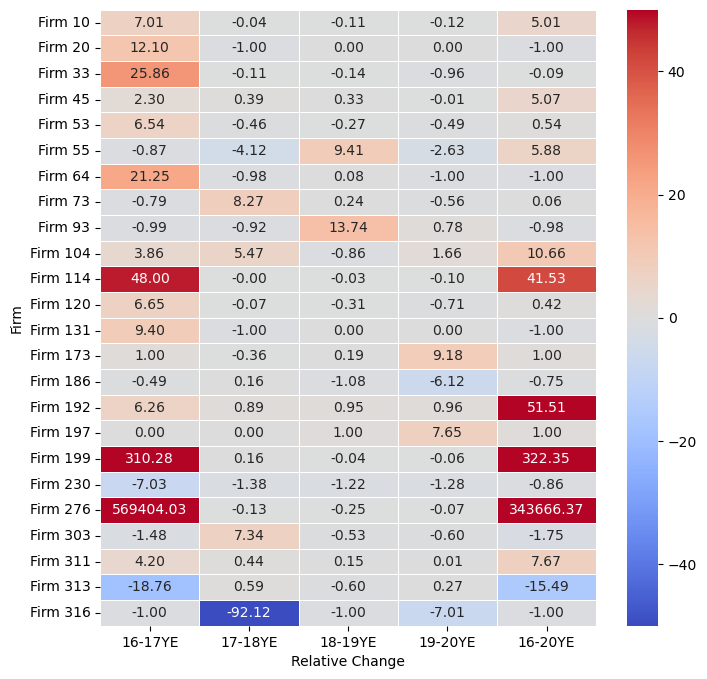

In [31]:
# To get the rows which percentage change is greater than 500%
tbl_gwp_change = gwp_change[gwp_change.abs().gt(5).any(axis=1)]
firms_GWP_change = list(tbl_gwp_change.index)
firms_GWP_change_2020 = list(gwp_change[gwp_change[('19-20YE')].abs().gt(5)].index)

# To visualise using heatmap
plt.figure(figsize=(8,8))
func_heatmap_relative_change(tbl_gwp_change)

From the graph, it shows the firms with percentage change over 500% (i.e. >5). As the firms' data are changing substantially year-on-year, it should receive attention. There is one particular firm (Firm 276) which data changes substantially from 2016 to 2017, but it is not identified as outlier. Attention should be paid to understand that.

<a id='NWP'></a>

### NWP
##### GWP less reinsurance.

#### NWP - Outliers

In [32]:
df_nwp = df_cleaned['NWP (£m)']
df_nwp

Year,2016YE,2017YE,2018YE,2019YE,2020YE
Firm,,,,,
Firm 1,-13779.8156,0.0000,0.0000,0.0000,0.0000
Firm 2,28.1781,26.8650,25.0644,23.2264,21.7186
Firm 3,0.0000,75.6097,70.5787,78.4328,85.7358
Firm 4,22344.1999,23963.9107,25760.3902,25512.7488,24996.0210
Firm 5,68.2010,51.6631,44.0108,42.0086,81.2737
...,...,...,...,...,...
Firm 321,0.0000,0.0000,-1.0114,-6.5991,24.6322
Firm 322,2092.1561,2084.1248,2022.2122,2103.0487,2029.6970
Firm 323,0.0000,0.0000,0.0000,0.0000,0.0000


In [33]:
# To check any firms containing all zeros
print('Total number of firms containing all zeros in terms of NWP:', len(func_check_zeros_row_list(df_nwp)))
df_nwp_all0 = df_nwp.index[(df_nwp==0).all(axis=1)].tolist()

# Remove these firms for statistics
df_nwp = df_nwp.loc[~(df_nwp==0).all(axis=1)]

Total number of firms containing all zeros in terms of NWP: 62


In [34]:
# To give an overview of the statistics
df_nwp.describe()

Year,2016YE,2017YE,2018YE,2019YE,2020YE
count,261.0000,261.0000,261.0000,261.0000,261.0000
mean,793.9549,995.6840,1050.9964,974.2194,819.7848
std,4293.2728,3643.0508,4089.3794,3830.6197,3369.8151
min,-13779.8156,-2305.8543,-193.0833,-181.6121,-1336.5533
25%,0.0010,3.5049,1.1836,0.0454,0.0000
50%,17.2423,28.2462,26.6504,20.4739,12.3676
75%,176.0223,325.2628,296.8994,206.9343,170.3573
max,45309.8387,38199.3113,48117.9937,44638.7696,40135.6923


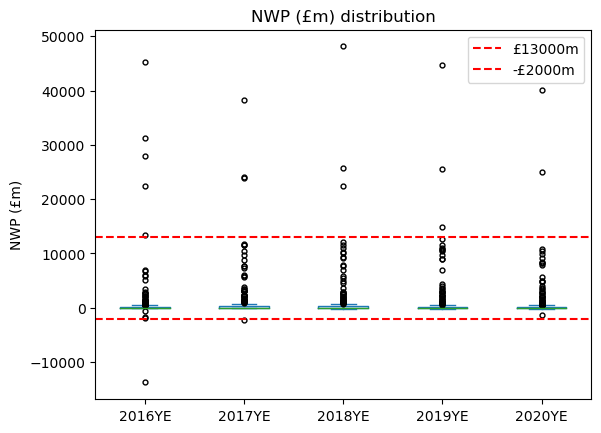

In [35]:
# To visualise the NWP (£m) distribution
func_plot_distribution_5yr('NWP (£m)')

# To add a dash line to identify outliers
func_draw_dashed_line(13000)
func_draw_dashed_line(-2000)

In [36]:
# To find the firms which values are over £13000m
ls_nwp_over = func_firms_values_over('NWP (£m)', 13000)
print('Firms having NWP outlier over £13000m:', str(len(ls_nwp_over)) + ' firms')
print(ls_nwp_over)
print()
# To find the firms which values are below -£2000m
ls_nwp_below = func_firms_values_below('NWP (£m)', -2000)
print('Firms having NWP outliers below -£2000m:', str(len(ls_nwp_below)) + ' firms')
print(ls_nwp_below)

Firms having NWP outlier over £13000m: 6 firms
['Firm 4', 'Firm 26', 'Firm 73', 'Firm 105', 'Firm 210', 'Firm 247']

Firms having NWP outliers below -£2000m: 2 firms
['Firm 1', 'Firm 66']


Again, all the circles are identified as outliers. As seen from the correlation map, GWP and NWP are greatly correlated. Therefore, I put those over £13000m and below -£2000 as extreme outliers to receive supervisory attention.  

NWP values could be negative due to the timing of reinsurance transactions. However, it is not desirable to see that so it is worth to focus as well. 

#### NWP - Firm size

,2020YE
Firm,
Firm 210,40135.6923
Firm 4,24996.0210
Firm 311,10830.9663
Firm 26,10489.2481
Firm 247,9961.5207
Firm 199,9134.2835
Firm 7,8359.9053
Firm 151,8180.3876
Firm 34,8145.6173


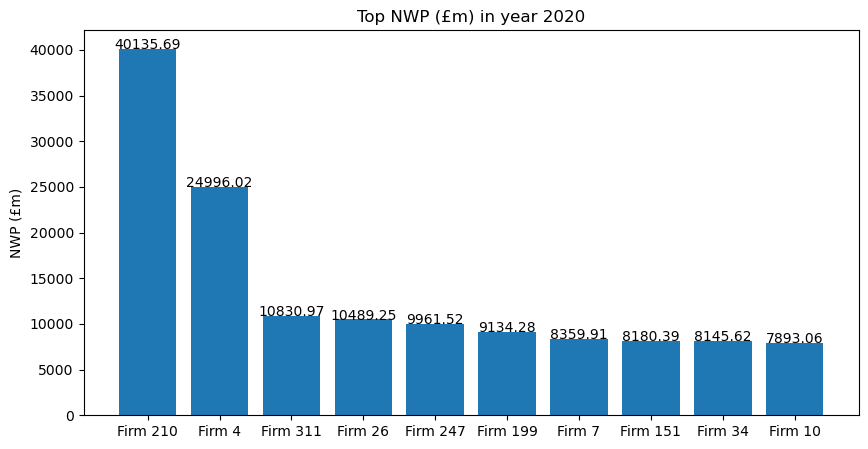

In [37]:
# To plot the top 10 GWP using bar charts
nwp_top_2020 = func_top_10_2020('NWP (£m)')
ls_nwp_top = list(nwp_top_2020.index)
func_plot_bar_top10_2020('NWP (£m)', nwp_top_2020)
nwp_top_2020

The graph and table show the firms with the top 10 NWP in 2020. They are 90% match with top 10 GWP firms in 2020, proving GWP and NWP and highly positively correlated. Again, biggest firms should receive more attention.

#### NWP - Changing business profile

In [38]:
# To compute the percentage change in years
nwp_change = func_relative_change('NWP (£m)')
nwp_change

Year,16-17YE,17-18YE,18-19YE,19-20YE,16-20YE
Firm,,,,,
Firm 1,-1.0000,0.0000,0.0000,0.0000,-1.0000
Firm 2,-0.0466,-0.0670,-0.0733,-0.0649,-0.2292
Firm 3,1.0000,-0.0665,0.1113,0.0931,1.0000
Firm 4,0.0725,0.0750,-0.0096,-0.0203,0.1187
Firm 5,-0.2425,-0.1481,-0.0455,0.9347,0.1917
...,...,...,...,...,...
Firm 319,-1.0000,1.0000,-1.0000,0.0000,-1.0000
Firm 321,0.0000,-1.0000,5.5249,-4.7327,1.0000
Firm 322,-0.0038,-0.0297,0.0400,-0.0349,-0.0299


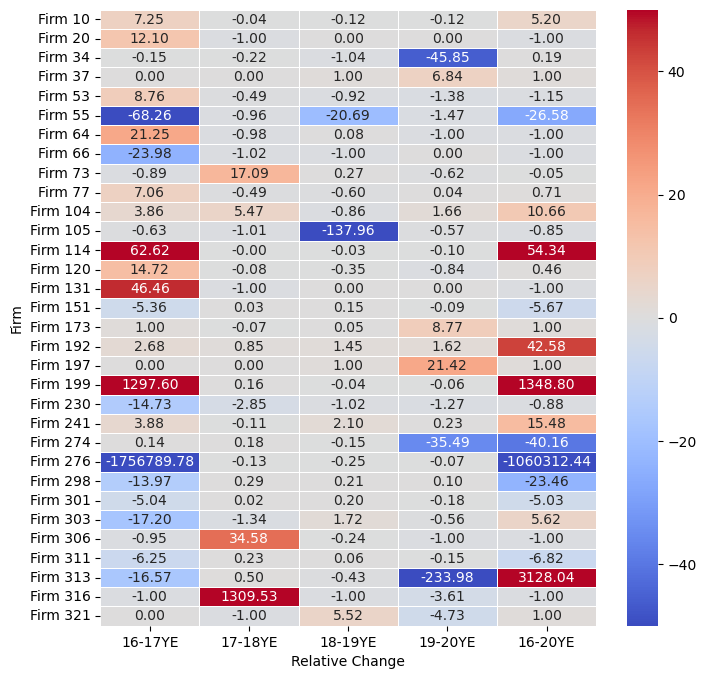

In [39]:
# To get the rows which percentage change is greater than 500%
tbl_nwp_change = nwp_change[nwp_change.abs().gt(5).any(axis=1)]
firms_NWP_change = list(tbl_nwp_change.index)
firms_NWP_change_2020 = list(nwp_change[nwp_change[('19-20YE')].abs().gt(5)].index)

# To visualise using heatmap
plt.figure(figsize=(8,8))
func_heatmap_relative_change(tbl_nwp_change)

From the graph, it shows the firms with percentage change over 500% (i.e. >5). As the firms' data are changing substantially year-on-year, it should receive attention. Again, firm 276 shows the greatest percentage change in NWP as with GWP. It proves that NWP and GWP are positively correlated and should be considered together as a NWP/GWP ratio.

<a id='NWPGWP'></a>

### NWP / GWP
##### Risk retention ratio shows how much of the firm's risk is being held internally without passing on to reinsurers.

In [40]:
# To compute the NWP/GWP ratio and sort from descending order
risk_ratio = df_cleaned_stats.reset_index().set_index('Firm')[['Year', 'GWP (£m)', 'NWP (£m)']]
# risk_ratio = risk_ratio[risk_ratio['Year'] == '2020YE']
risk_ratio['NWP/GWP'] = risk_ratio['NWP (£m)'] / risk_ratio['GWP (£m)']
risk_ratio = risk_ratio.sort_values('NWP/GWP', ascending = False)
risk_ratio

Metrics,Year,GWP (£m),NWP (£m),NWP/GWP
Firm,,,,
Firm 21,2020YE,0.0000,0.0181,inf
Firm 55,2017YE,-1.7990,-64.6790,35.9525
Firm 230,2018YE,0.0660,0.8243,12.4814
Firm 225,2018YE,0.0006,0.0047,7.5502
Firm 303,2020YE,0.0029,0.0199,6.8209
...,...,...,...,...
Firm 318,2020YE,0.0000,0.0000,NaN
Firm 319,2020YE,0.0000,0.0000,NaN
Firm 320,2020YE,0.0000,0.0000,NaN


The top two firms appear to be error in reporting. If GWP is zero, it should mean no business operation and hence NWP should be 0. Firm 55 has negative GWP which has already raised in GWP outlier section. At the end of the list there are many NaN ratio due to zero division, meaning no business operation in that year and therefore I drop it for ratio analysis. In the below cell, it shows the list from the largest ratio to the least ratio.

In [41]:
# To show the list again without NaN values which are irrelevant
risk_ratio.dropna()

Metrics,Year,GWP (£m),NWP (£m),NWP/GWP
Firm,,,,
Firm 21,2020YE,0.0000,0.0181,inf
Firm 55,2017YE,-1.7990,-64.6790,35.9525
Firm 230,2018YE,0.0660,0.8243,12.4814
Firm 225,2018YE,0.0006,0.0047,7.5502
Firm 303,2020YE,0.0029,0.0199,6.8209
...,...,...,...,...
Firm 93,2018YE,0.0810,-1.1756,-14.5181
Firm 233,2020YE,-0.0060,0.0903,-14.9287
Firm 303,2017YE,0.0019,-0.0488,-26.2433


In [42]:
# To find NWP/GWP ratio larger than 1
risk_ratio_weird = risk_ratio[(risk_ratio.iloc[:, -1]).abs().gt(1)]
risk_ratio_weird

Metrics,Year,GWP (£m),NWP (£m),NWP/GWP
Firm,,,,
Firm 21,2020YE,0.0000,0.0181,inf
Firm 55,2017YE,-1.7990,-64.6790,35.9525
Firm 230,2018YE,0.0660,0.8243,12.4814
Firm 225,2018YE,0.0006,0.0047,7.5502
Firm 303,2020YE,0.0029,0.0199,6.8209
...,...,...,...,...
Firm 93,2018YE,0.0810,-1.1756,-14.5181
Firm 233,2020YE,-0.0060,0.0903,-14.9287
Firm 303,2017YE,0.0019,-0.0488,-26.2433


As NWP/GWP ratio provides an approximate measure of how much risk the firm carries internally rather than passing on to reinsurers, ratio greater than 1 suggests the firms have assumed additional risks, resulting in unhealthy business. Therefore, it is worth to pay attention. 

In [43]:
# Add this information to the record
ls_firms_ratio_weird = list(risk_ratio_weird.index)
ls_firms_ratio_weird_2020 = list(risk_ratio_weird[risk_ratio_weird['Year']=='2020YE'].index)

<a id='SCRCR'></a>

### SCR coverage ratio
##### A measure of whether a firm is meeting its prudential capital requirements. Greater than 100% means the firm is holding enough capital to meet the requirement.

#### SCR - Holding enough capital

In [44]:
df_scrcr = df_cleaned['SCR coverage ratio']
df_scrcr

Year,2016YE,2017YE,2018YE,2019YE,2020YE
Firm,,,,,
Firm 1,1.9799,481792000.0000,0.0000,0.0000,0.0000
Firm 2,3.1574,3.8718,5.1371,6.8133,3.9009
Firm 3,1.7414,1.4805,1.5056,1.4622,1.2987
Firm 4,1.3874,1.3861,1.4245,1.5032,1.4145
Firm 5,2.7076,3.6810,4.2270,2.3989,1.8995
...,...,...,...,...,...
Firm 321,0.0000,14.3239,1.7154,4.5026,1.6975
Firm 322,1.1864,1.3512,1.4864,1.4258,1.3818
Firm 323,1.2768,3.9057,11.5842,38.2088,2.6602


In [45]:
# To check any firms containing all zeros
print('Total number of firms containing all zeros in terms of SCR coverage ratio:', len(func_check_zeros_row_list(df_scrcr)))
df_scrcr.loc[(df_scrcr==0).all(axis=1)]

Total number of firms containing all zeros in terms of SCR coverage ratio: 17


Year,2016YE,2017YE,2018YE,2019YE,2020YE
Firm,,,,,
Firm 8,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 11,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 29,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 50,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 65,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 68,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 112,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 116,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 128,0.0000,0.0000,0.0000,0.0000,0.0000


In [46]:
# To validate these firms with GWP and NWP, proving they have no business operation
SCR_0_validate = []
for i in df_scrcr.loc[(df_scrcr==0).all(axis=1)].index:
    if i in natsorted(set(df_nwp_all0 + df_gwp_all0)):
        SCR_0_validate.append(True)
    else:
        SCR_0_validate.append(False)
print('Check if all firms showing all 0 in SCR coverage ratio have no business in GWP and NWP:', all(SCR_0_validate))

# Remove these firms for statistics
ls_scrcr_0_any = list(df_scrcr[(df_scrcr == 0).any(axis=1)].index)
ls_scrcr_0_2020 = list(df_scrcr[(df_scrcr['2020YE']==0)].index)
# ls_scrcr_0 = list(df_scrcr.loc[(df_scrcr==0).all(axis=1)].index)
df_scrcr = df_scrcr.loc[~(df_scrcr==0).all(axis=1)]

Check if all firms showing all 0 in SCR coverage ratio have no business in GWP and NWP: True


Although these firms have zero SCR coverage ratio which fails to meet the capital requirement, I cross validate with GWP and NWP to find that their values are zero as well, meaning they have no business. It appears that I should focus on the others which SCR coverage ratio is less than 1.

In [47]:
# To give an overview of the statistics
df_scrcr.describe()

Year,2016YE,2017YE,2018YE,2019YE,2020YE
count,306.0000,306.0000,306.0000,306.0000,306.0000
mean,13668.5565,6298534.6356,13241.5296,566.1130,546.1435
std,239044.4284,67279737.2868,220678.1816,9830.9162,9512.0094
min,-1.9744,-1.9737,-0.5515,-0.6690,-1.0665
25%,1.3232,1.3588,1.3273,1.2853,0.9762
50%,1.7391,1.8261,1.7671,1.7577,1.6243
75%,2.8394,3.3081,3.0567,2.7818,2.4451
max,4181572.9807,963584000.0000,3856018.2346,171974.6908,166394.5759


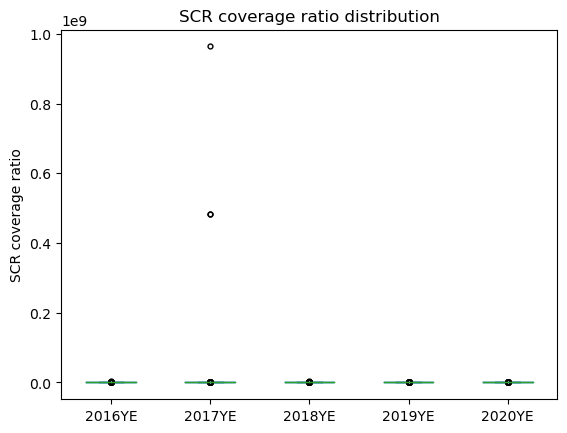

In [48]:
# To visualise the SCR coverage ratio distribution
func_plot_distribution_5yr('SCR coverage ratio')

In [49]:
# To find the firms which values are over 100
ls_scrcr_over = func_firms_values_over('SCR coverage ratio', 100)
print('Firms having SCR coverage ratio outlier over 100:', str(len(ls_scrcr_over)) + ' firms')
print(ls_scrcr_over)
print()
# To find the firms which values are extreme outliers
ls_scrcr_ext = func_firms_values_over('SCR coverage ratio', 1e8)
print('Firms possibly having SCR coverage ratio error (extreme points):', str(len(ls_scrcr_ext)) + ' firms')
print(ls_scrcr_ext)

Firms having SCR coverage ratio outlier over 100: 7 firms
['Firm 1', 'Firm 66', 'Firm 127', 'Firm 131', 'Firm 216', 'Firm 291', 'Firm 320']

Firms possibly having SCR coverage ratio error (extreme points): 3 firms
['Firm 1', 'Firm 131', 'Firm 216']


In [50]:
ls_scrcr_below = func_firms_values_below('SCR coverage ratio', 1)

ls_scrcr_below1_ex0 = []
for i in ls_scrcr_below:
    if i not in ls_scrcr_0_any:
        ls_scrcr_below1_ex0.append(i)
print(ls_scrcr_below1_ex0)
print('Firms having SCR coverage ratio below 1 (100%):', str(len(ls_scrcr_below1_ex0)) + ' firms')
print()
ls_scrcr_below_2020 = func_firms_values_below_2020('SCR coverage ratio', 1)
ls_scrcr_below1_ex0_2020 = []
for i in ls_scrcr_below_2020:
    if i not in ls_scrcr_0_2020:
        ls_scrcr_below1_ex0_2020.append(i)
print(ls_scrcr_below1_ex0_2020)
print('Firms having SCR coverage ratio below 1 (100%) in 2020:', str(len(ls_scrcr_below1_ex0_2020)) + ' firms')
# print(ls_scrcr_below_2020)

['Firm 40', 'Firm 83', 'Firm 88', 'Firm 109', 'Firm 141', 'Firm 148', 'Firm 149', 'Firm 183', 'Firm 213', 'Firm 241', 'Firm 256', 'Firm 264', 'Firm 285']
Firms having SCR coverage ratio below 1 (100%): 13 firms

['Firm 109', 'Firm 141', 'Firm 148', 'Firm 213']
Firms having SCR coverage ratio below 1 (100%) in 2020: 4 firms


After removing rows that have all zeros in SCR coverage ratio, there are still a number of firms which show 0 from time to time. It appears that their SCR coverage ratio could be fluctuate, therefore is worth to pay attention. For the other firms which SCR coverage ratio is less than 1, it means they are not holding enough capital to meet the requirement. Therefore, it is the highest priority to pay supervisory attention to these firms

#### SCR coverage ratio - Top 10

In [51]:
# Sort SCR coverage ratio for year 2020
scr_ratio_top_2020 = func_top_10_2020('SCR coverage ratio')
ls_scrcr_top = list(scr_ratio_top_2020.index)
scr_ratio_top_2020

,2020YE
Firm,
Firm 127,166394.5759
Firm 177,23.4362
Firm 312,21.8555
Firm 232,18.5730
Firm 190,16.0276
Firm 133,15.4079
Firm 282,15.2329
Firm 300,14.3468
Firm 278,13.6465


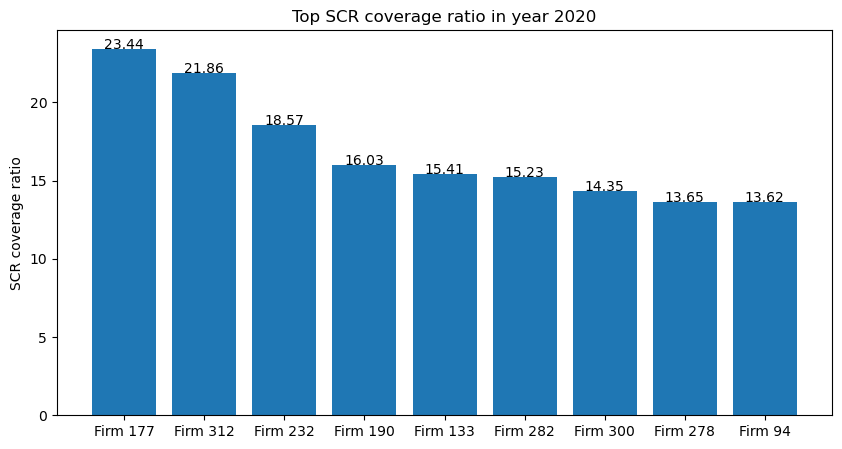

In [52]:
func_plot_bar_top10_2020('SCR coverage ratio', scr_ratio_top_2020[1:])

From the table, there is one firm (Firm 127) who has an extreme SCR coverage ratio. It appears to be an error in reporting as it is so different to all other firms.

#### SCR coverage ratio - Changing business profile

In [53]:
# To compute the percentage change in years
scrcr_change = func_relative_change('SCR coverage ratio')
scrcr_change

Year,16-17YE,17-18YE,18-19YE,19-20YE,16-20YE
Firm,,,,,
Firm 1,243345920.1986,-1.0000,0.0000,0.0000,-1.0000
Firm 2,0.2262,0.3268,0.3263,-0.4275,0.2355
Firm 3,-0.1499,0.0170,-0.0288,-0.1118,-0.2542
Firm 4,-0.0009,0.0277,0.0552,-0.0590,0.0196
Firm 5,0.3595,0.1483,-0.4325,-0.2082,-0.2985
...,...,...,...,...,...
Firm 321,1.0000,-0.8802,1.6249,-0.6230,1.0000
Firm 322,0.1389,0.1001,-0.0408,-0.0309,0.1647
Firm 323,2.0589,1.9660,2.2984,-0.9304,1.0834


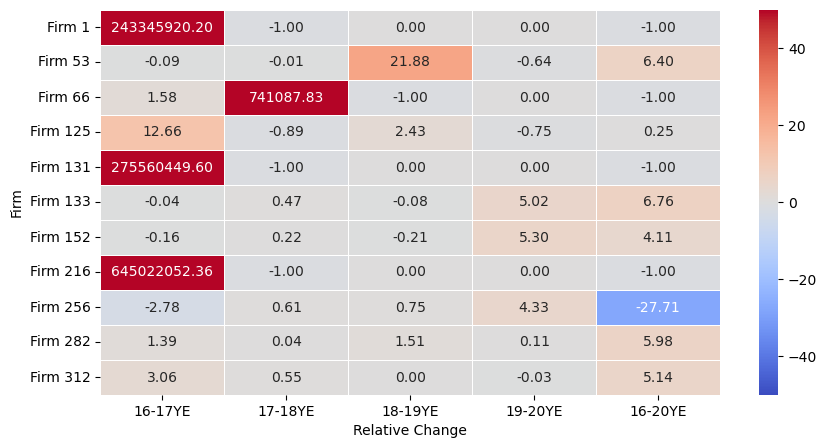

In [54]:
# To get the rows which percentage change is greater than 500%
tbl_scrcr_change = scrcr_change[scrcr_change.abs().gt(5).any(axis=1)]
firms_SCRCR_change = list(tbl_scrcr_change.index)
firms_SCRCR_change_2020 = list(scrcr_change[scrcr_change[('19-20YE')].abs().gt(5)].index)

# To visualise using heatmap
plt.figure(figsize=(10,5))
func_heatmap_relative_change(tbl_scrcr_change)

From the graph, it shows the firms with relative change over 500% (i.e. >5). As the firms' data are changing substantially year-on-year, especially as the capital requirement, it should receive attention. I found that the four firms (i.e. Firm 1, 66, 131, 216) with the greatest percentage change (i.e. darkest red colour) are also identified as outliers. It is likely an error in reporting, being worth to pay attention. 

<a id='GCI'></a>

### Gross claims incurred
##### A large cost to an insurer. Monitoring how these change over time for a firm is vital.

#### GCI - Outliers

In [55]:
df_gci = df_cleaned['Gross claims incurred (£m)']
df_gci

Year,2016YE,2017YE,2018YE,2019YE,2020YE
Firm,,,,,
Firm 1,0.0000,0.0467,0.0000,0.0000,0.0000
Firm 2,39.2411,35.9482,29.0022,0.0000,0.0000
Firm 3,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 4,17.1260,75.5360,119.4270,35.8842,6.5680
Firm 5,30.4852,247.8730,449.8747,348.5363,373.7868
...,...,...,...,...,...
Firm 321,4.9287,4.8087,4.8100,4.7980,3.4658
Firm 322,82.7420,96.4270,83.2893,125.9950,200.6946
Firm 323,0.0000,0.0000,0.0000,0.0000,0.0000


In [56]:
# To check any firms containing all zeros
print('Total number of firms containing all zeros in terms of Gross claims incurred:', len(func_check_zeros_row_list(df_gci)))

# Remove these firms for statistics
df_gci = df_gci.loc[~(df_gci==0).all(axis=1)]

Total number of firms containing all zeros in terms of Gross claims incurred: 86


In [57]:
# To give an overview of the statistics
df_gci.describe()

Year,2016YE,2017YE,2018YE,2019YE,2020YE
count,237.0000,237.0000,237.0000,237.0000,237.0000
mean,180.4634,204.7940,199.9199,180.7833,177.0300
std,510.5217,481.7688,462.4412,450.0940,396.3621
min,-43.1491,-98.0003,-42.5268,-18.2954,-20.8376
25%,0.0675,0.4269,1.3741,0.0405,0.0000
50%,22.3075,35.0718,37.5537,31.9398,21.9844
75%,133.4323,166.7382,198.7671,160.6724,170.8479
max,4487.9094,3807.9868,3731.1013,3734.2045,3089.4564


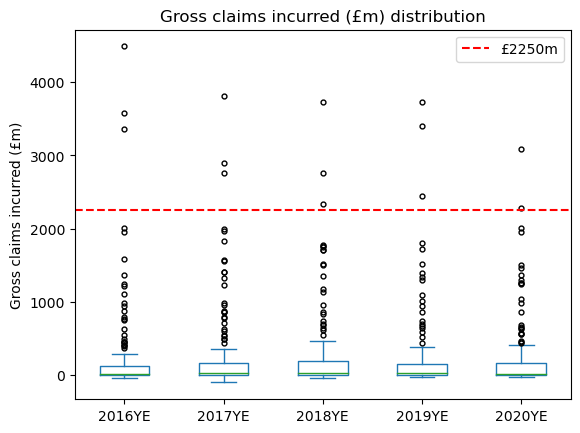

In [58]:
# To visualise the Gross claims incurred (£m) distribution
func_plot_distribution_5yr('Gross claims incurred (£m)')

# To add a dash line to identify outliers
func_draw_dashed_line(2250)

In [59]:
# To find the firms which GWP values are over £2250m
ls_gci_over = func_firms_values_over('Gross claims incurred (£m)', 2250)
print('Firms having Gross claims incurred outlier over £2250m:', str(len(ls_gci_over)) + ' firms')
print(ls_gci_over)
print()

Firms having Gross claims incurred outlier over £2250m: 4 firms
['Firm 17', 'Firm 105', 'Firm 112', 'Firm 216']



From the graph, there are some extreme outliers which I identified as over £2250m. They should receive attention to understand the reason of large cost of paid claims.

#### GCI - Top 10

,2020YE
Firm,
Firm 112,3089.4564
Firm 17,2289.6220
Firm 105,2010.3701
Firm 52,1952.4890
Firm 283,1499.4502
Firm 74,1468.9063
Firm 22,1364.6064
Firm 304,1301.1699
Firm 286,1258.3036


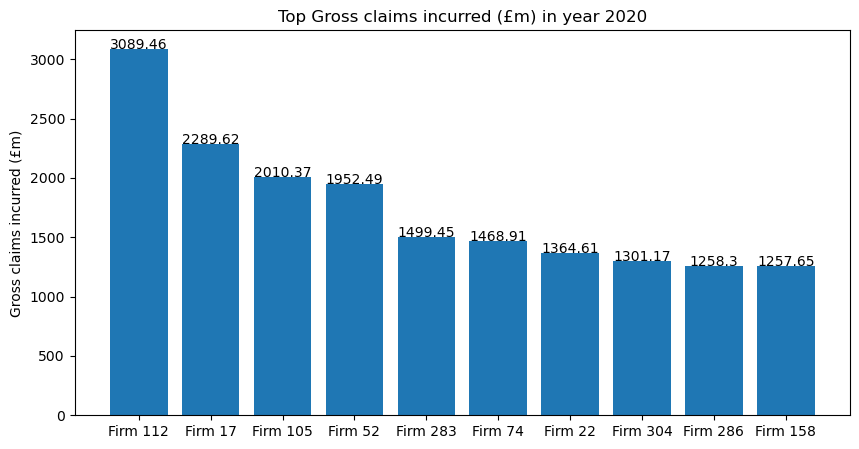

In [60]:
# Sort SCR coverage ratio for year 2020
gci_top_2020 = func_top_10_2020('Gross claims incurred (£m)')
ls_gci_top = list(gci_top_2020.index)
func_plot_bar_top10_2020('Gross claims incurred (£m)', gci_top_2020)
gci_top_2020

The graph and table show the firms with the top 10 Gross claims incurred in 2020. Higher gross claims incurred may result in higher possibility of weakening firms' liquidity, therefore they should receive attention.

#### GCI - Changing business profile

In [61]:
# To compute the percentage change in years
gci_change = func_relative_change('Gross claims incurred (£m)')
gci_change

Year,16-17YE,17-18YE,18-19YE,19-20YE,16-20YE
Firm,,,,,
Firm 1,1.0000,-1.0000,0.0000,0.0000,0.0000
Firm 2,-0.0839,-0.1932,-1.0000,0.0000,-1.0000
Firm 4,3.4106,0.5811,-0.6995,-0.8170,-0.6165
Firm 5,7.1309,0.8149,-0.2253,0.0724,11.2613
Firm 6,-0.4259,0.0504,-0.2434,-0.0495,-0.5664
...,...,...,...,...,...
Firm 319,2.5730,-0.8115,-0.8329,41.4790,3.7808
Firm 321,-0.0243,0.0003,-0.0025,-0.2777,-0.2968
Firm 322,0.1654,-0.1362,0.5127,0.5929,1.4255


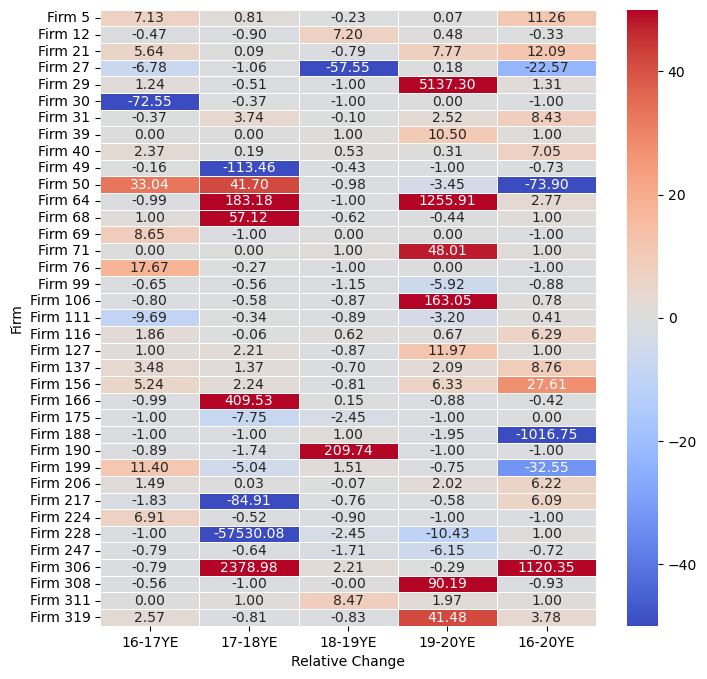

In [62]:
# To get the rows which percentage change is greater than 500%
tbl_gci_change = gci_change[gci_change.abs().gt(5).any(axis=1)]
firms_GCI_change = list(tbl_gci_change.index)
firms_GCI_change_2020 = list(gci_change[gci_change[('19-20YE')].abs().gt(5)].index)

# To visualise using heatmap
plt.figure(figsize=(8,8))
func_heatmap_relative_change(tbl_gci_change)

From the graph, it shows the firms with percentage change over 500% (i.e. >5). As the firms' data are changing substantially year-on-year, it should receive attention. I found that there are three firms (i.e. Firm 29, 64, 306) having extreme percentage change over 100000% (i.e. >1000) but they are not seen as outliers. They should be paid attention to understand the reason substantial change in data. 

<a id='NCR'></a>

### Net combined ratio

#### NCR - Outliers

In [63]:
df_ncr = df_cleaned['Net combined ratio']
df_ncr

Year,2016YE,2017YE,2018YE,2019YE,2020YE
Firm,,,,,
Firm 1,0.0000,68.2152,0.0000,0.0000,0.0000
Firm 2,0.9553,1.1569,0.9436,0.0000,0.0000
Firm 3,0.0000,0.0000,0.0000,0.0000,0.0000
Firm 4,1.0802,1.7073,2.1190,2.5863,-3.4085
Firm 5,0.7560,1.5693,1.5221,1.3090,1.0621
...,...,...,...,...,...
Firm 321,0.9780,1.0027,0.9725,0.9584,0.8169
Firm 322,1.5670,1.5948,1.5474,1.4186,1.1685
Firm 323,0.0000,0.0000,0.0000,0.0000,0.0000


In [64]:
# To check any firms containing all zeros
print('Total number of firms containing all zeros in terms of Net combined ratio:', len(func_check_zeros_row_list(df_ncr)))

# Remove these firms for statistics
df_ncr = df_ncr.loc[~(df_ncr==0).all(axis=1)]

Total number of firms containing all zeros in terms of Net combined ratio: 107


In [65]:
# To give an overview of the statistics
df_ncr.describe()

Year,2016YE,2017YE,2018YE,2019YE,2020YE
count,216.0000,216.0000,216.0000,216.0000,216.0000
mean,2.0303,-200.1894,9.0071,11250.8209,14.8257
std,18.5314,3141.4719,107.7686,165342.0673,116.4139
min,-124.2884,-46116.6968,-2.0139,-251.6977,-9.4908
25%,0.5212,0.7422,0.7967,0.6362,0.2701
50%,0.9216,0.9651,0.9530,0.9376,0.9145
75%,1.0369,1.1221,1.0597,1.0460,1.0754
max,198.0071,1738.2958,1578.8539,2430022.8396,1076.1587


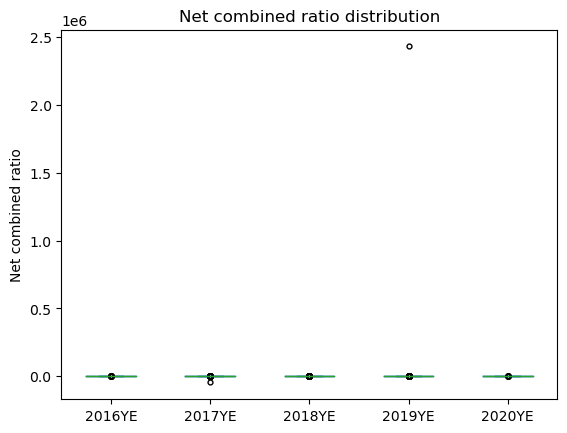

In [66]:
# To visualise the Net combined ratio distribution
func_plot_distribution_5yr('Net combined ratio')

In [67]:
# To find the firms which Net combined ratio values are over 100 (10000%)
ls_ncr_over = func_firms_values_over('Net combined ratio', 100)
print('Firms having Net combined ratio outlier over 100 (10000%):', str(len(ls_ncr_over)) + ' firms')
print(ls_ncr_over)
print()
# To find the firms which values are extreme outliers
ls_ncr_ext = func_firms_values_over('Net combined ratio', 1e5)
print('Firms possibly having Net combined ratio error (extreme points):', str(len(ls_ncr_ext)) + ' firms')
print(ls_ncr_ext)

Firms having Net combined ratio outlier over 100 (10000%): 8 firms
['Firm 28', 'Firm 70', 'Firm 72', 'Firm 161', 'Firm 166', 'Firm 188', 'Firm 228', 'Firm 284']

Firms possibly having Net combined ratio error (extreme points): 1 firms
['Firm 188']


In [68]:
# To find the firms which Net combined ratio values are negative (<0&)
ls_ncr_below = func_firms_values_below('Net combined ratio', 0)
print('Firms possibly having Net combined ratio error from negative (<0%):', str(len(ls_ncr_below)) + ' firms')
print(ls_ncr_below)
print()
ls_ncr_below_2020 = func_firms_values_below_2020('Net combined ratio', 0)
print('Firms possibly having Net combined ratio error from ngative (<0%) in 2020:', str(len(ls_ncr_below_2020)) + ' firms')
print(ls_ncr_below_2020)
# df_ncr.drop(index = ls_ncr_below, inplace = True)

Firms possibly having Net combined ratio error from negative (<0%): 24 firms
['Firm 4', 'Firm 8', 'Firm 28', 'Firm 47', 'Firm 49', 'Firm 50', 'Firm 51', 'Firm 55', 'Firm 69', 'Firm 72', 'Firm 99', 'Firm 146', 'Firm 151', 'Firm 161', 'Firm 166', 'Firm 190', 'Firm 191', 'Firm 209', 'Firm 246', 'Firm 251', 'Firm 257', 'Firm 262', 'Firm 308', 'Firm 318']

Firms possibly having Net combined ratio error from ngative (<0%) in 2020: 4 firms
['Firm 4', 'Firm 209', 'Firm 251', 'Firm 308']


From the graph, we can see there is one extreme point in 2019. It appears to be error in reporting, if not, it suggests that firm (i.e. Firm 188) has the least profitability. Regardless of whichever reason, it should receive attention. Moreover, I found out there are 8 firms which its Net combined ratio values over 100 (>10000%), suggesting these firms are in really poor profitability. Therefore, we should focus on these firms.

Net combined ratio is assumed to be non-negative, as it is the ratio to indicate the profitability. Less than 1 indicates a profit while more than 1 suggests the firm may be in poor financial health. However, there are 24 firms in total which recorded negative net combined ratio. It appears to be errors in reporting, and I will delete these for further analysis

#### NCR - Worst 10 and Best 10

In [69]:
# Sort Net combined ratio for year 2020
ncr_top_2020 = func_top_10_2020('Net combined ratio')
ls_ncr_top = list(ncr_top_2020.index)
ncr_top_2020

,2020YE
Firm,
Firm 228,1076.1587
Firm 166,989.1554
Firm 284,906.3079
Firm 72,49.5114
Firm 178,21.0037
Firm 39,5.7726
Firm 146,5.4452
Firm 88,4.0614
Firm 203,3.1171


The table shows the highest 10 Net combined ratio which means the least profitability. Again, the top 3 firms were also detected as outliers. These should be paid attention.

In [70]:
ncr_best = pd.DataFrame(df_ncr[('2020YE')][df_ncr[('2020YE')] > 0].sort_values()).head(10)
ls_ncr_best = list(ncr_best.index)
ncr_best

,2020YE
Firm,
Firm 49,0.0029
Firm 129,0.0739
Firm 151,0.1185
Firm 190,0.2276
Firm 41,0.2843
Firm 294,0.3006
Firm 180,0.3236
Firm 247,0.3674
Firm 24,0.4396


The table shows the lowest Net combined ratio which means the highest profitability. Some of these also appear on the list of top 10 of the other metrics, suggesting they may be in big size. Therefore, we should also focus on them.

#### NCR - Changing business profile

In [71]:
# To compute the percentage change in years
ncr_change = func_relative_change('Net combined ratio')
ncr_change

Year,16-17YE,17-18YE,18-19YE,19-20YE,16-20YE
Firm,,,,,
Firm 1,1.0000,-1.0000,0.0000,0.0000,0.0000
Firm 2,0.2111,-0.1844,-1.0000,0.0000,-1.0000
Firm 4,0.5805,0.2412,0.2205,-2.3179,-4.1554
Firm 5,1.0759,-0.0301,-0.1400,-0.1886,0.4049
Firm 6,-0.1377,-0.0093,-0.0237,-0.0763,-0.2296
...,...,...,...,...,...
Firm 318,-1.3802,-21.1096,0.1612,-0.3652,4.6362
Firm 319,1.2737,-0.6509,-0.6220,5.6960,1.0086
Firm 321,0.0252,-0.0301,-0.0145,-0.1477,-0.1648


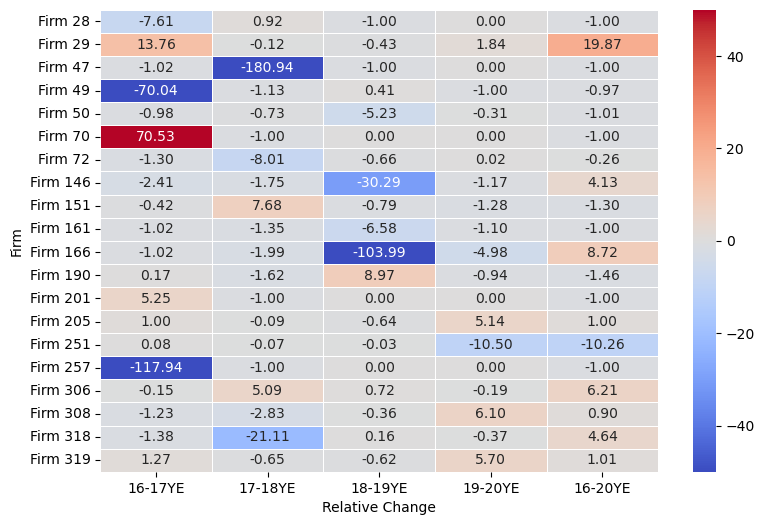

In [72]:
# To get the rows which percentage change is greater than 500%
tbl_ncr_change = ncr_change[ncr_change.abs().gt(5).any(axis=1)]
firms_NCR_change = list(tbl_ncr_change.index)
firms_NCR_change_2020 = list(ncr_change[ncr_change[('19-20YE')].abs().gt(5)].index)

# To visualise using heatmap
plt.figure(figsize=(9,6))
func_heatmap_relative_change(tbl_ncr_change)

From the graph, it shows the firms with percentage change over 500% (i.e. >5). As the firms' data are changing substantially year-on-year, it should receive attention. I found that there is one firm (i.e. Firm 70) having extreme percentage change over 7000% (i.e. >70) and it is also seen as an outlier. All these firms should receive attention as their data are changing substantially. 

<a id='TA'></a>

### Total assets
##### Useful for evaluating the firm size

#### Total assets - Outliers

In [73]:
df_ta = df_cleaned['Total assets (£m)']
df_ta

Year,2016YE,2017YE,2018YE,2019YE,2020YE
Firm,,,,,
Firm 1,71727.5931,4.8179,0.0000,0.0000,0.0000
Firm 2,41.9175,50.2230,59.2176,64.5352,38.1787
Firm 3,1509.7163,1575.3185,1540.8072,1630.8357,1754.9791
Firm 4,67404.3491,73034.6293,81184.8293,84801.5240,94065.0810
Firm 5,341.8593,311.5090,271.1161,249.7489,235.4819
...,...,...,...,...,...
Firm 321,0.0000,3.8560,1592.2170,1746.3363,6850.2955
Firm 322,6463.4206,6729.5687,6143.9704,5825.2328,5885.1181
Firm 323,72.4276,101.9469,81.6008,73.1821,13.1959


In [74]:
# To check any firms containing all zeros
print('Total number of firms containing all zeros in terms of total assets:', len(func_check_zeros_row_list(df_ta)))

# Remove these firms for statistics
df_ta = df_ta.loc[~(df_ta==0).all(axis=1)]

Total number of firms containing all zeros in terms of total assets: 17


In [75]:
# To give an overview of the statistics
df_ta.describe()

Year,2016YE,2017YE,2018YE,2019YE,2020YE
count,306.0000,306.0000,306.0000,306.0000,306.0000
mean,7524.4485,7699.3345,7360.3545,8081.9824,8033.8992
std,27295.5814,31491.1625,29832.8498,33276.0242,34365.5115
min,0.0000,-54.5268,-161.9543,-217.4298,-83.9976
25%,33.4825,28.1888,27.0253,17.3489,4.0456
50%,200.0079,172.6110,155.2532,130.0396,76.0121
75%,1409.3249,1206.0028,1169.7641,1039.9678,920.8482
max,284329.9045,298172.8430,282829.5454,311228.3694,332875.9036


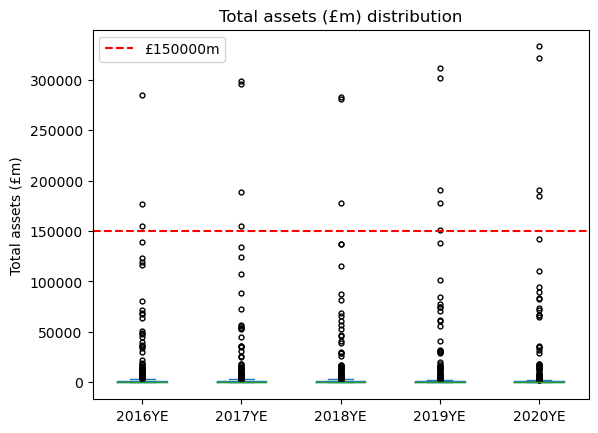

In [76]:
# To visualise the Net combined ratio distribution
func_plot_distribution_5yr('Total assets (£m)')

# To add a dash line to identify outliers
func_draw_dashed_line(150000)

In [77]:
# To find the firms which total assets values are over £150000m
ls_ta_over = func_firms_values_over('Total assets (£m)', 150000)
print('Firms having Total assets outlier over £150000m:', str(len(ls_ta_over)) + ' firms')
print(ls_ta_over)

Firms having Total assets outlier over £150000m: 6 firms
['Firm 10', 'Firm 34', 'Firm 101', 'Firm 105', 'Firm 210', 'Firm 311']


In [78]:
# To find the firms which total assets values are negative (<£0m)
ls_ta_below = func_firms_values_below('Total assets (£m)', 0)
print('Firms possibly having Total assets error from ngative (<0m):', str(len(ls_ta_below)) + ' firms')
print(ls_ta_below)
print()
ls_ta_below_2020 = func_firms_values_below_2020('Total assets (£m)', 0)
print('Firms possibly having Total assets error from ngative (<0m) in 2020:', str(len(ls_ta_below_2020)) + ' firms')
print(ls_ta_below_2020)

Firms possibly having Total assets error from ngative (<0m): 2 firms
['Firm 150', 'Firm 192']

Firms possibly having Total assets error from ngative (<0m) in 2020: 1 firms
['Firm 150']


From the graph, I identify extreme outliers as firms' total assets values over £150000m. These data points deviate significantly from the average and should receive supervisory attention. Moreover, there are two firms (i.e. Firm 150, 192) which have negative total assets, suggesting error in reporting.

#### Total assets - Top 10

,2020YE
Firm,
Firm 210,332875.9036
Firm 311,321563.5998
Firm 105,190431.2075
Firm 34,185108.3286
Firm 10,142144.9871
Firm 7,110371.6641
Firm 4,94065.0810
Firm 73,89412.1663
Firm 199,83298.9423


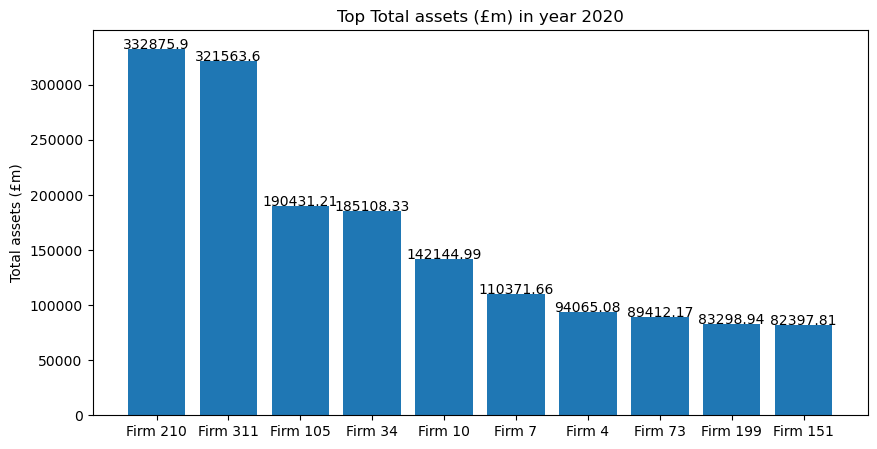

In [79]:
# Sort Net combined ratio for year 2020
ta_top_2020 = func_top_10_2020('Total assets (£m)')
ls_ta_top = list(ta_top_2020.index)
func_plot_bar_top10_2020('Total assets (£m)', ta_top_2020)
ta_top_2020

The graph and table show the firms with the top 10 Total assets in 2020. Higher total assets may result in bigger firm size, therefore they should receive attention.

<a id='Summary'></a>

### Summary

To sum up the total number of firms that should receive attention, I analysed the following characteristics for each metric.  
- Best 10 / Worst 10
- Substantially changing data
- Outliers / Strange data points

In [80]:
# Group the firms which have issues for each metric

# GWP
ls_gwp = list(set(ls_gwp_over + ls_gwp_below + firms_GWP_change + ls_gwp_top))
# NWP 
ls_nwp = list(set(ls_nwp_over + ls_nwp_below + firms_NWP_change + ls_nwp_top))
# NWP/GWP
ls_nwpgwp = list(set(ls_firms_ratio_weird))
# SCR coverage ratio
ls_scrcr = list(set(ls_scrcr_over + ls_scrcr_below1_ex0 + firms_SCRCR_change + ls_scrcr_top))
# Gross claims incurred 
ls_gci = list(set(ls_gci_over + firms_GCI_change + ls_gci_top))
# Net combined ratio
ls_ncr = list(set(ls_ncr_over + ls_ncr_below + firms_NCR_change + ls_ncr_top + ls_ncr_best))
# Total assets
ls_ta = list(set(ls_ta_over + ls_ta_below + ls_ta_top))

# All
total = ls_gwp+ls_nwp+ls_nwpgwp+ls_scrcr+ls_gci+ls_ncr+ls_ta

In [81]:
print('Total number of firms that should be supervised:', len(set(total)))

Total number of firms that should be supervised: 148


As there are 148 firms in total that should be supervised, I made prioritisation to allocate scarce resources to investigate the firms.

#### 1st priority

In [82]:
# SCR coverage ratio < 1 in 2020
print(ls_scrcr_below1_ex0_2020)

['Firm 109', 'Firm 141', 'Firm 148', 'Firm 213']


In [83]:
# SCR coverage ratio < 1 over the years
print(ls_scrcr_below1_ex0)

['Firm 40', 'Firm 83', 'Firm 88', 'Firm 109', 'Firm 141', 'Firm 148', 'Firm 149', 'Firm 183', 'Firm 213', 'Firm 241', 'Firm 256', 'Firm 264', 'Firm 285']


#### 2nd priority

In [84]:
# NWP/GWP ratio > 1 in 2020
print(ls_firms_ratio_weird_2020)

['Firm 21', 'Firm 303', 'Firm 152', 'Firm 76', 'Firm 61', 'Firm 28', 'Firm 233', 'Firm 274', 'Firm 313']


In [85]:
# NWP/GWP ratio > 1 over the years
print(ls_firms_ratio_weird)

['Firm 21', 'Firm 55', 'Firm 230', 'Firm 225', 'Firm 303', 'Firm 303', 'Firm 225', 'Firm 131', 'Firm 225', 'Firm 152', 'Firm 230', 'Firm 207', 'Firm 277', 'Firm 28', 'Firm 313', 'Firm 76', 'Firm 76', 'Firm 76', 'Firm 76', 'Firm 7', 'Firm 96', 'Firm 313', 'Firm 96', 'Firm 61', 'Firm 230', 'Firm 277', 'Firm 303', 'Firm 61', 'Firm 277', 'Firm 313', 'Firm 121', 'Firm 28', 'Firm 121', 'Firm 230', 'Firm 121', 'Firm 28', 'Firm 26', 'Firm 62', 'Firm 62', 'Firm 62', 'Firm 93', 'Firm 61', 'Firm 316', 'Firm 33', 'Firm 278', 'Firm 1', 'Firm 207', 'Firm 66', 'Firm 93', 'Firm 233', 'Firm 303', 'Firm 274', 'Firm 313']


#### Other considerations

In [86]:
# To count the number of issues a Firm has

# To initiate an empty dataframe to count the number of issues
issue_count = pd.DataFrame()
issue_count.index = df.index
issue_count['Issue counts'] = 0

for i in range(1, 326):
    # if found in the list, update the value
    if 'Firm ' + str(i) in total:
        issue_count.loc['Firm ' + str(i), 'Issue counts'] = total.count('Firm ' + str(i))
# To sort the issue count from descending to know which firms have the most issues
pd.DataFrame(issue_count['Issue counts'].sort_values(ascending = False)).head(30)

,Issue counts
Firm 151,4
Firm 105,4
Firm 55,4
Firm 4,4
Firm 7,4
Firm 199,4
Firm 247,4
Firm 131,4
Firm 311,4
Firm 313,3


#### Challenges

Relying on the simple count of the number of issues the firms have may be problematic. It is because all analysed metrics are given equal weightings, while some metrics may be more important than others.  

Moreover, it may also double counted the issues because of the correlation. For example, GWP and NWP have a significantly positive correlation.  

Last but not least, there is also data quality issue. Thoughout the analysis, I found out a lot of firms' data appear to be errors in reporting, such as zero values, negative values and extreme data points.